In [116]:
import json 
import random
from sklearn.metrics import f1_score
from code.printers import pretty_print_conl
from sklearn.metrics import f1_score
from __future__ import division
from code.treeops import bfs
dev = [json.loads(_) for _ in open("dev.jsonl")]
train = [json.loads(_) for _ in open("mini.train.jsonl")]

In [115]:
dev[0]["original"]

u'Resources led the JSE lower on Tuesday amid profit taking following a good short-term run.'

In [91]:
def heuristic_extract(jdoc):
    '''
    return the lowest vertex in the tree that contains the query terms
    '''
    from_root = [_['dependent'] for _ in jdoc["basicDependencies"] if _['governor'] == 0][0]
    best = from_root
    def tok_is_verb(vertex):
        gov = [o["pos"][0] for o in jdoc["tokens"] if o["index"] == v][0]
        return gov[0].lower() == "v"
    for v in get_walk_from_root(jdoc):  # bfs
        children = dfs(g=jdoc, hop_s=v, D=[])
        # the verb heuristic is b/c the min governing tree is often just Q itself
        if all(i in children for i in jdoc["q"]) and tok_is_verb(v):
            best = v
    return best

def get_path_to_root(v, jdoc):
    def get_parent(v):
        for _ in jdoc["basicDependencies"]:
            if _["dependent"] == v:
                return _["governor"]
        return _["governor"]
    out = [v]
    parent = get_parent(v)
    while parent != 0:
        v = parent
        out.append(parent)
        parent = get_parent(v)
    return out

def min_tree_to_root(jdoc):
    return {i for q in jdoc["q"] for i in get_path_to_root(q, jdoc)}

def len_tree(tree, jdoc):
    return sum(len(o['word']) for o in jdoc["tokens"] if o["index"] in tree)


def get_options(tree, jdoc):
    optionsd = {o["dependent"] for o in jdoc["basicDependencies"] if o["governor"] in tree and o["dependent"] not in tree}
    optionsg = {o["governor"] for o in jdoc["basicDependencies"] if o["dependent"] in tree and o["governor"] not in tree}
    return optionsd | optionsg
    
def append_at_random(tree, jdoc):
    s = get_options(tree, jdoc)
    added = random.sample(s, 1)[0]
    assert added not in tree
    tree.add(added)

def bottom_up_compression_random(jdoc):
    tree = min_tree_to_root(jdoc=jdoc)
    while len_tree(tree=tree, jdoc=jdoc) < jdoc["r"]:
        try:
            append_at_random(tree, jdoc)
        except ValueError: # it is possible to back into a corner where there are no V left to add.
                           # in these cases, you cant make compression longer and should just stop
            return tree
    return tree

def print_gold(jdoc):
    gold = jdoc["compression_indexes"]
    print " ".join([_["word"] for _ in jdoc["tokens"] if _["index"] in gold])

def print_tree(tree, jdoc):
    tk = [_["word"] for _ in jdoc["tokens"] if _["index"] in tree]
    print " ".join(tk)
    
def get_f1(predicted, jdoc):
    original_ixs = [_["index"] for _ in jdoc["tokens"]]
    y_true = [_ in jdoc['compression_indexes'] for _ in original_ixs]
    y_pred = [_ in predicted for _ in original_ixs]
    return f1_score(y_true=y_true, y_pred=y_pred)

def f1_experiment(sentence_set, f=bottom_up_compression_random):
    tot = 0
    for sentence in sentence_set:
        predicted = f(sentence)
        tot += get_f1(predicted, sentence)
    return tot/len(lns)

f1_experiment(dev)

0.6611305836257646

In [117]:
from collections import defaultdict

dep_counter = defaultdict(list)

from tqdm import tqdm_notebook as tqdm

for _ in tqdm(train):
    toks = [i for i in _["tokens"] if i["index"] in _["compression_indexes"] + [0]]
    for t in toks:
        gov = [d["dep"] for d in _["basicDependencies"] if d["dependent"] == t["index"]]
        assert len(gov) == 1
        gov = gov[0]
        dep = [d["dep"] for d in _["basicDependencies"] if d["governor"] == t["index"]]
        for d in dep:
            dep_counter[gov].append(d)

from collections import Counter

dep_probs = defaultdict()
for d in dep_counter:
    c = Counter(dep_counter[d])
    c = {k:v/sum(c.values()) for k,v in c.items()}
    dep_probs[d] = c
    
print dep_probs['root']

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))


{u'cc': 0.021613832853025938, u'nmod:tmod': 0.009726224783861672, u'compound:prt': 0.0032420749279538905, u'nsubjpass': 0.011527377521613832, u'csubj': 0.00036023054755043225, u'conj': 0.024135446685878963, u'dobj': 0.03710374639769452, u'neg': 0.005403458213256484, u'discourse': 0.00036023054755043225, u'mark': 0.0036023054755043226, u'auxpass': 0.010806916426512969, u'advcl': 0.01729106628242075, u'aux': 0.03386167146974063, u'parataxis': 0.013328530259365994, u'xcomp': 0.0223342939481268, u'nsubj': 0.07853025936599424, u'nummod': 0.007204610951008645, u'advmod': 0.016210374639769452, u'punct': 0.3076368876080692, u'compound': 0.08213256484149856, u'ccomp': 0.012968299711815562, u'nmod:poss': 0.008645533141210375, u'case': 0.013688760806916427, u'cop': 0.010806916426512969, u'dep': 0.03386167146974063, u'appos': 0.009726224783861672, u'det': 0.03314121037463977, u'nmod': 0.1026657060518732, u'amod': 0.02881844380403458, u'acl:relcl': 0.016930835734870316, u'iobj': 0.0003602305475504

In [118]:
def add_children_to_q(vx, q, sentence, tree):
    '''add a vertexes children to a queue, sort by prob'''
    children = [d for d in sentence['basicDependencies'] if d["governor"] == vx if d["dep"] not in ["punct"]]
    governor = [d for d in sentence['basicDependencies'] if d["dependent"] == vx][0]
    for c in children:
        try:
            c["prob"] = dep_probs[governor["dep"]][c["dep"]]
        except KeyError:
            c["prob"] = 0
        if c["dependent"] not in tree:
            q.append(c)
    q.sort(key=lambda x:x["prob"], reverse=True)

def remove_from_q(vx, Q, sentence):
    '''add a vertexes children to a queue, sort by prob'''
    for ino, i in enumerate(Q):
        if i["dependent"] == vx:
            del Q[ino]
            break

def bottom_up_from_corpus_nops(sentence):            
    tree = min_tree_to_root(jdoc=sentence)
    q_by_prob = []
    for item in tree:
        add_children_to_q(item, q_by_prob, sentence, tree)
    
    nops = 0
    while len_tree(tree, sentence) < sentence["r"]:
        try:
            new_vx = q_by_prob[0]["dependent"]
            tree.add(new_vx)
            add_children_to_q(new_vx, q_by_prob, sentence, tree)
            remove_from_q(new_vx, q_by_prob, sentence)
            nops += 1
        except IndexError:
            print "[*] Index error" # these are mostly parse errors from punct governing parts of the tree.
            return nops
    return nops
            
def bottom_up_from_corpus(sentence):            
    tree = min_tree_to_root(jdoc=sentence)
    q_by_prob = []
    for item in tree:
        add_children_to_q(item, q_by_prob, sentence, tree)

    
    while len_tree(tree, sentence) < sentence["r"]:
        try:
            new_vx = q_by_prob[0]["dependent"]
            tree.add(new_vx)
            add_children_to_q(new_vx, q_by_prob, sentence, tree)
            remove_from_q(new_vx, q_by_prob, sentence)
        except IndexError:
            print "[*] Index error" # these are mostly parse errors from punct governing parts of the tree.
            return tree 
    
    return tree

f1_experiment(dev,f=bottom_up_from_corpus)

#slens = defaultdict(list)
#for d in dev:
#    slen = len(d["tokens"])
#    if slen < 30:
#        nops = bottom_up_from_corpus_nops(d)
#        slens[slen].append(nops)

[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error
[*] Index error


0.72104090332269211

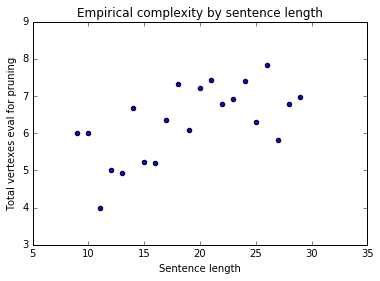

In [119]:
import matplotlib.pyplot as plt
import numpy as np
x, y = [], []

for s in slens:
    x.append(s)
    y.append(np.mean(slens[s]))

plt.scatter(x, y)
plt.title("Empirical complexity by sentence length")
plt.ylabel("Total vertexes eval for pruning")
plt.xlabel("Sentence length")